# Demo Notebook
This notebook is intended to act as a primer and overview of the functionality found in the various libraries written for this repository. Additional comments and information can be found in the inline comments within the library scripts.

As a whole, this repository is intended to be a series of functions and libraries to establish a simple, simulated mobile robot in an environment with a smooth function of interest distributed in it. This robot is gathering information about this data, and our code allows the robot to make myopic or nonmyopic planning decisions with respect to the previous observations it has made. We will use this notebook to walk you through setting up an enviroment, creating a robot, and simulating the planning actions it can take.

## Primer

Several key concepts are critical to the development of this repository. This section intends to walk through some of these in order to build more detailed intuition about what the robot is doing in it's adaptive sampling regime.

### Gaussian Processes
We assume that the function distributed in the environment is smooth and Gaussian -- think geography (rolling hills), temperature plumes in water, or oil slicks. This allows us to use *Gaussian Processes* (GPs) as a model of our environment, and provides closed-form solutions for incrementally updating the robot's belief model as it explores, allowing for probabilistic predictions of values, and more.

### POMDPs
A *Partially-Observable Markov Decision Process* (POMDP) is a problem which consists of a value function (a sense of reward), a set of actions (which can be executed to accumulate reward), a set of transition probabilities (the probabiliy to actually executing an action and ending up where we anticipate), observations (which is what we get when we take an action), a set of states (which is the status of the robot between actions or transitions, and where observations can occur), and occasionally other factors like a discount factor (the idea that as we accumulate more actions, their value can decrease). To be *partially observable* means that some of the states, observations, or actions/transitions are not known to us prior to selecting an action, and we end up discovering those things along the way. For an adaptive sampling problem like ours, we assume that we always know where the robot is, but not what it will observe (as in, the environment itself is only partially observable at any action selection).

### Monte Carlo Tree Search
There are a number of ways to solve POMDP problems, and we've ultimately decided to go with a tree search. A *Monte Carlo Tree Search* (MCTS) walks through potential actions that a vehicle can take at any moment, and predicts the most fruitful chains of actions to explore based on the value function (which we're learning as we go as we take observations). The leafs in the tree search can be of one of two forms: a "belief" node -- that is, what the robot believes its state and the environment's state to be, and a belief-action node -- that is, what the robot believes its state and environment's state to be *after* taking an action. MCTS allows us to expand these types of leaves, using accumulated predicted value. The tree is expanded to a certain *horizon* before it determines the accumulated reward of the action sequence it has planned. It will repeat these expansions to a specific computation budget.

### Quantifying Valuable Actions
In order to select the most valueable type of action at any step, we need to select a reward function which will encourage the type of behavior we desire -- in our case, we want the robot to find, with confidence, the "best" or "most optimal" or "largest maxima" in the environment. You could consider this the place with the largest methane signal in a hydrothermal vent site, or the deepest canyon in a hilly landscape. While it is cananical to use a value function called the *Upper Confidence Bound* (UCB) which weighs the predicted mean and variance of a point; we've opted to use the *Maximum Value Information* (MVI) metric, inspired by work by Wang and Jegelka on [Maximum-Value Entropy Search](https://arxiv.org/pdf/1703.01968.pdf). This function explicitly weighs the entropy of the predicted maximum value to the predicted value of another state in the world. As we observe more, our estimate of the maximum-value improves (since we assume a smooth, Gaussian distribution), and our estimate of the value of a state becomes more accurate. 

### The Typical Routine
The robot initially starts out with no *a priori* information -- that is, everywhere in the world looks just as good as anywhere else in the world. It selects an initially random action. It executes this action, and along the way collects true observations of the environment, and updates its belief model. At the end of the action, the robot selects a new action, now considering the updated belief model. It continues this pattern until some termination is reached (either it has exhausted a time or computation budget, or perhaps it has converged on a desired state). 

## Imports

There are several libraries which are external to what is provided by our repository. Please be aware that you will need to be running Python 2.7+, and you will need to have *maptlotlib, sklearn, iPython, numpy, scipy, time* and *itertools* available. Additionally, you will likely need to download *GPy* and *dubins*, non-standard python libraries. You can get these with the following commands (in a terminal):
        
        ``` pip install GPy ```
        ``` pip install dubins ```

Or you can visit [this page](https://github.com/SheffieldML/GPy) for GPy, and [this page](https://github.com/AndrewWalker/Dubins-Curves) for dubins download details.

In [1]:
#standard imports
import os
import time
import sys
import logging
import numpy as np

#repository libraries, which contain calls for matplotlib, GPy, dubins, etc.
import aq_library as aqlib
import mcts_library as mctslib
import gpmodel_library as gplib 
import evaluation_library as evalib 
import paths_library as pathlib 
import envmodel_library as envlib 
import robot_library as roblib
import obstacles as obslib

## Default Parameters
We use a few "global" variables to parameterize our robot and our environment. 

* SEED - specifies a foundational distribution from which the environment function can be drawn. Takes on any number 0 through 1 million
* REWARD_FUNCTION - specifies how a piece of information/an observation by the robot is valued; can take the value *mes* for Maximum Entropy Search value, *mean* for the Upper Confidence Bound value, or *exp_improve* for the Expected Improvement Value
* PATHSET - the path primitives available to the vehicle; can take on the value *fully_reachable* for point-to-point or *dubins* for a pre-specified set of dubins curves
* USE_COST - a boolean for whether to consider path length when planning
* NONMYOPIC - a boolean for whether the planner that the robot uses should be myopic or nonmyopic
* GOAL-ONLY - a boolean for whether only the destination point (goal) is used to determine the reward of a trajectory, or whether the entire trajectory is considered
* TREE_TYPE - for a nonmyopic planner, the search tree can be selected; can take on the value *belief* for a classical Monte Carlo Search Tree or *dpw* for a tree which utilizes progressive-widening techniques

* MIN_COLOR - for plotting, the value of the smallest observation available
* MAX_COLOR - for plotting, the value of the largest observation available

In [2]:
# You can set these depending on the type of robot and environment you want to generate
SEED =  0
REWARD_FUNCTION = 'mes' #robot will use Maximum Value Information as value function
PATHSET = 'dubins' #robot will have a set of pre-defined action sets to use for each step of planning
USE_COST = False #since all of the path options will be nominally the same length anyway in the dubins setting, robot doesn't consider path length cost
NONMYOPIC = True #robot will consider future outcomes for each action
GOAL_ONLY = False #robot will consider the whole trajectory with respect to reward
TREE_TYPE = 'dpw' #robot will use progressive widening in the search tree

# Parameters for plotting based on the seed world information
MIN_COLOR = -25.
MAX_COLOR = 25.

## Logging and IPython Set-Up
The next two code cells set up a logging system which will write files to your local machine; saving the mission run for later review, and allowing the figures and other elements that will generate during a simulated mission to populate within this notebook.

In [3]:
# Set up paths for logging the data from the simulation run
if not os.path.exists('./figures/' + str(REWARD_FUNCTION)): 
    os.makedirs('./figures/' + str(REWARD_FUNCTION))
logging.basicConfig(filename = './figures/'+ REWARD_FUNCTION + '/robot.log', level = logging.INFO)
logger = logging.getLogger('robot')

In [4]:
%matplotlib inline
%load_ext autoreload
%aimport ipp_library
%autoreload 1

## Creating the Environment

We will establish a "world" in which our robot will explore. We will use the *obstacles* and *Environment Library* in order to create these.

In [5]:
# First, establish the extent of the world; assume rectangular
ranges = (0., 10., 0., 10.)

### Obstacles
We can create a number of different types of obstacle worlds. Examples below.

In [6]:
ow = obslib.FreeWorld() #a world without obstacles

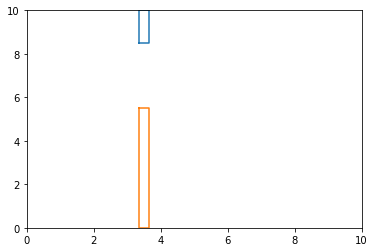

In [7]:
ow_channel = obslib.ChannelWorld(extent=ranges, 
                                 opening_location=(3.5, 7.), 
                                 opening_size= 3., 
                                 wall_thickness=0.3)
ow_channel.draw_obstacles()

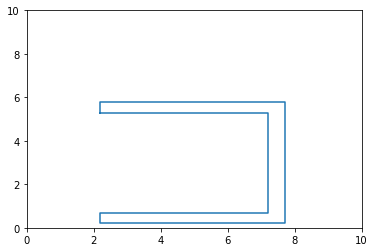

In [8]:
ow_bug = obslib.BugTrap(extent=ranges, 
                        opening_location=(2.2, 3.0), 
                        opening_size=4.6, 
                        orientation = 'left', 
                        width = 5.0)
ow_bug.draw_obstacles()

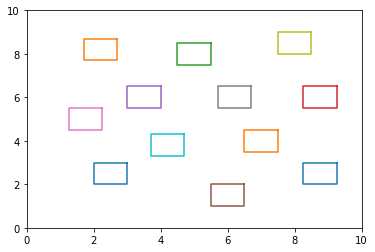

In [9]:
ow_blocks = obslib.BlockWorld(extent=ranges,
                              num_blocks=12, 
                              dim_blocks=(1., 1.), 
                              centers=[(2.5, 2.5), (7.,4.), (5., 8.), (8.75, 6.), (3.5,6.), (6.,1.5), (1.75,5.), (6.2,6.), (8.,8.5), (4.2, 3.8), (8.75,2.5), (2.2,8.2)])
ow_blocks.draw_obstacles()

### Function
Now, we need to create the underlying function that we want the robot to discover.

In [10]:
world = envlib.Environment(ranges = ranges,
                           NUM_PTS = 20, 
                           variance = 100.0, 
                           lengthscale = 1.0, 
                           visualize = True,
                           seed = SEED,
                           MIN_COLOR=MIN_COLOR, 
                           MAX_COLOR=MAX_COLOR, 
                           obstacle_world = ow,
                           noise=10.0)

Generating environment for time 0
Current environment in violation of boundary constraint. Regenerating!


ValueError: all the input arrays must have same number of dimensions

## Evaluation

We use the *Evaluation Library* in order to create an "evaluator" object which can be used by the robot to determine how well it is doing as it explores.

In [17]:
# Create the evaluation class used to quantify the simulation metrics
evaluation = evalib.Evaluation(world = world, reward_function = REWARD_FUNCTION)

World max value 27.744079714634324 at location [2.10526316 1.05263158]


## The Robot
Finally, we establish our point robot using a number of different parameters, which are fully detailed in the *Robot Library* in this repository.

In [23]:
robot = roblib.Robot(sample_world = world.sample_value, #function handle for collecting observations
                     start_loc = (5.0, 5.0, 0.0), #where robot is instantiated
                     extent = ranges, #extent of the explorable environment
                     kernel_file = None,
                     kernel_dataset = None,
                     #prior_dataset =  (data, observations), 
                     prior_dataset = None,
                     init_lengthscale = 1.0, 
                     init_variance = 100.0, 
                     noise = 10.0001,
                     #noise = 0.5000,
                     path_generator = PATHSET, #options: default, dubins, equal_dubins, fully_reachable_goal, fully_reachable_step
                     goal_only = GOAL_ONLY, #select only if using fully reachable step and you want the reward of the step to only be the goal
                     frontier_size = 15,
                     horizon_length = 1.5, 
                     turning_radius = 0.05,
                     sample_step = 0.5,
                     evaluation = evaluation, 
                     f_rew = REWARD_FUNCTION, 
                     create_animation = True, #logs images to the file folder
                     learn_params = False, #if kernel params should be trained online
                     nonmyopic = NONMYOPIC,
                     discretization = (20, 20), #parameterizes the fully reachable sets
                     use_cost = USE_COST, #select if you want to use a cost heuristic
                     MIN_COLOR = MIN_COLOR,
                     MAX_COLOR = MAX_COLOR,
                     computation_budget = 250.0,
                     rollout_length = 5,
                     obstacle_world = ow, 
                     tree_type = TREE_TYPE) 

## Executing a Mission
We have created simple method calls within the robot class in order to execute a mission.

[ 0 ] Current Location:   (5.0, 5.0, 0.0)
Current predicted max and value: 	[0. 0.] 	0.0
Setting c to : 1.0
Rollouts completed in 1.68485593796s
Number of rollouts: 250
# nodes in tree: 10950
[(17, 5.0), (17, 5.0), (17, 5.0), (17, 5.0), (16, 5.0), (17, 5.0), (16, 5.0), (16, 5.0), (17, 5.0), (16, 5.0), (16, 5.0), (17, 5.0), (17, 5.0), (17, 5.0), (17, 5.0)]
[ 1 ] Current Location:   (5.335149778313376, 6.44263505832286, 1.3695422350712745)
Current predicted max and value: 	[5.51724138 6.89655172] 	4.9449031356635995
Setting c to : 1.0
Starting global optimization 0 of 3
Max Value in Optimization 	 	[23.94244467]
Starting global optimization 1 of 3
Max Value in Optimization 	 	[31.98301938]
Starting global optimization 2 of 3
Max Value in Optimization 	 	[36.57238735]
Rollouts completed in 3.03742408752s
Number of rollouts: 250
# nodes in tree: 8230
[(2, 3.1077275376689384), (2, 3.58387482401934), (2, 3.7229715318278624), (2, 3.7558707470018127), (3, 4.270147255360079), (4, 4.405765696072

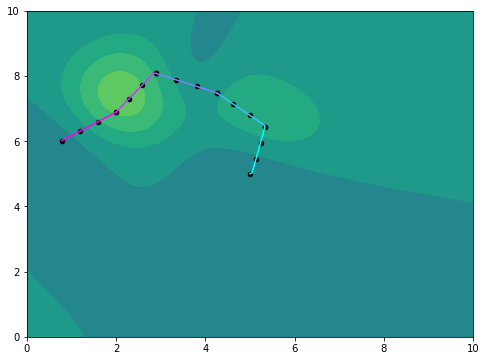

In [24]:
# Establisht the number of "steps" or "actions" the robot should take in the total mission using T
robot.planner(T = 5) #robot will plan 5 actions
robot.visualize_trajectory(screen = True) #creates a summary trajectory image
# robot.plot_information() #plots all of the metrics of interest